In [11]:
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import select
from sqlalchemy.orm import Session, aliased
from mc_postgres_db.models import Asset, Provider, ProviderAssetOrder
from mc_postgres_db.prefect.asyncio.tasks import get_engine

In [12]:
engine = await get_engine()

11:46:36.502 | WARNING | prefect.client - Your Prefect server is running an older version of Prefect than your client which may result in unexpected behavior. Please upgrade your Prefect server from version 3.4.7 to version 3.4.8 or higher.

11:46:36.572 | INFO    | Task run 'get_engine' - Finished in state Completed()

In [13]:
with Session(engine) as session:
    stmt = select(Asset).where(Asset.is_active)
    assets = session.scalars(stmt).all()
    asset_pair: dict[int, str] = {asset.id: asset.name for asset in assets}
    print("Available assets:")
    for asset_id, asset_name in asset_pair.items():
        print(f"{asset_id}: {asset_name}")
asset_1 = 1
asset_2 = 2
start_datetime = datetime.now() - timedelta(days=1)
end_datetime = datetime.now()
print(
    f"Comparing {asset_pair[asset_1]} and {asset_pair[asset_2]} from {start_datetime} onwards"
)

Available assets:
1: BTC
2: USD
3: ETH
4: XRP
5: BNB
Comparing BTC and USD from 2025-07-17 11:46:36.995464 onwards


In [14]:
# Create aliases for Asset to use in multiple joins
FromAsset = aliased(Asset)
ToAsset = aliased(Asset)

# Create the query
with Session(engine) as session:
    stmt = (
        select(
            ProviderAssetOrder.id,
            ProviderAssetOrder.timestamp,
            ProviderAssetOrder.price,
            ProviderAssetOrder.volume,
            FromAsset.name.label("from_asset_name"),
            ToAsset.name.label("to_asset_name"),
            Provider.name.label("provider_name"),
        )
        .join(FromAsset, ProviderAssetOrder.from_asset_id == FromAsset.id)
        .join(ToAsset, ProviderAssetOrder.to_asset_id == ToAsset.id)
        .join(Provider, ProviderAssetOrder.provider_id == Provider.id)
    )

    stmt = stmt.where(
        ((FromAsset.id == asset_1) & (ToAsset.id == asset_2))
        | ((FromAsset.id == asset_2) & (ToAsset.id == asset_1)),
        ProviderAssetOrder.timestamp >= start_datetime,
        ProviderAssetOrder.timestamp <= end_datetime,
    ).order_by(ProviderAssetOrder.timestamp)

    result_df = pd.read_sql(stmt, session.bind)

result_df

,id,timestamp,price,volume,from_asset_name,to_asset_name,provider_name
0,37701931,2025-07-17 11:46:37,119649.6,10.661,BTC,USD,Kraken
1,37701935,2025-07-17 11:46:39,119248.5,0.508,BTC,USD,Kraken
2,37701940,2025-07-17 11:46:42,118360.1,4.265,BTC,USD,Kraken
3,37701941,2025-07-17 11:46:42,118094.4,0.014,USD,BTC,Kraken
4,37702393,2025-07-17 11:46:42,118094.4,0.014,USD,BTC,Kraken
...,...,...,...,...,...,...,...
560198,39203903,2025-07-18 10:46:01,118910.4,0.019,USD,BTC,Kraken
560199,39203895,2025-07-18 10:46:01,119268.2,0.211,BTC,USD,Kraken
560200,39203906,2025-07-18 10:46:01,118941.7,2.102,USD,BTC,Kraken
560201,39203905,2025-07-18 10:46:01,118921.1,0.014,USD,BTC,Kraken


/var/folders/tc/qpkxsjrx4s72nqyhf67_1ctw0000gn/T/ipykernel_24477/3574328447.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


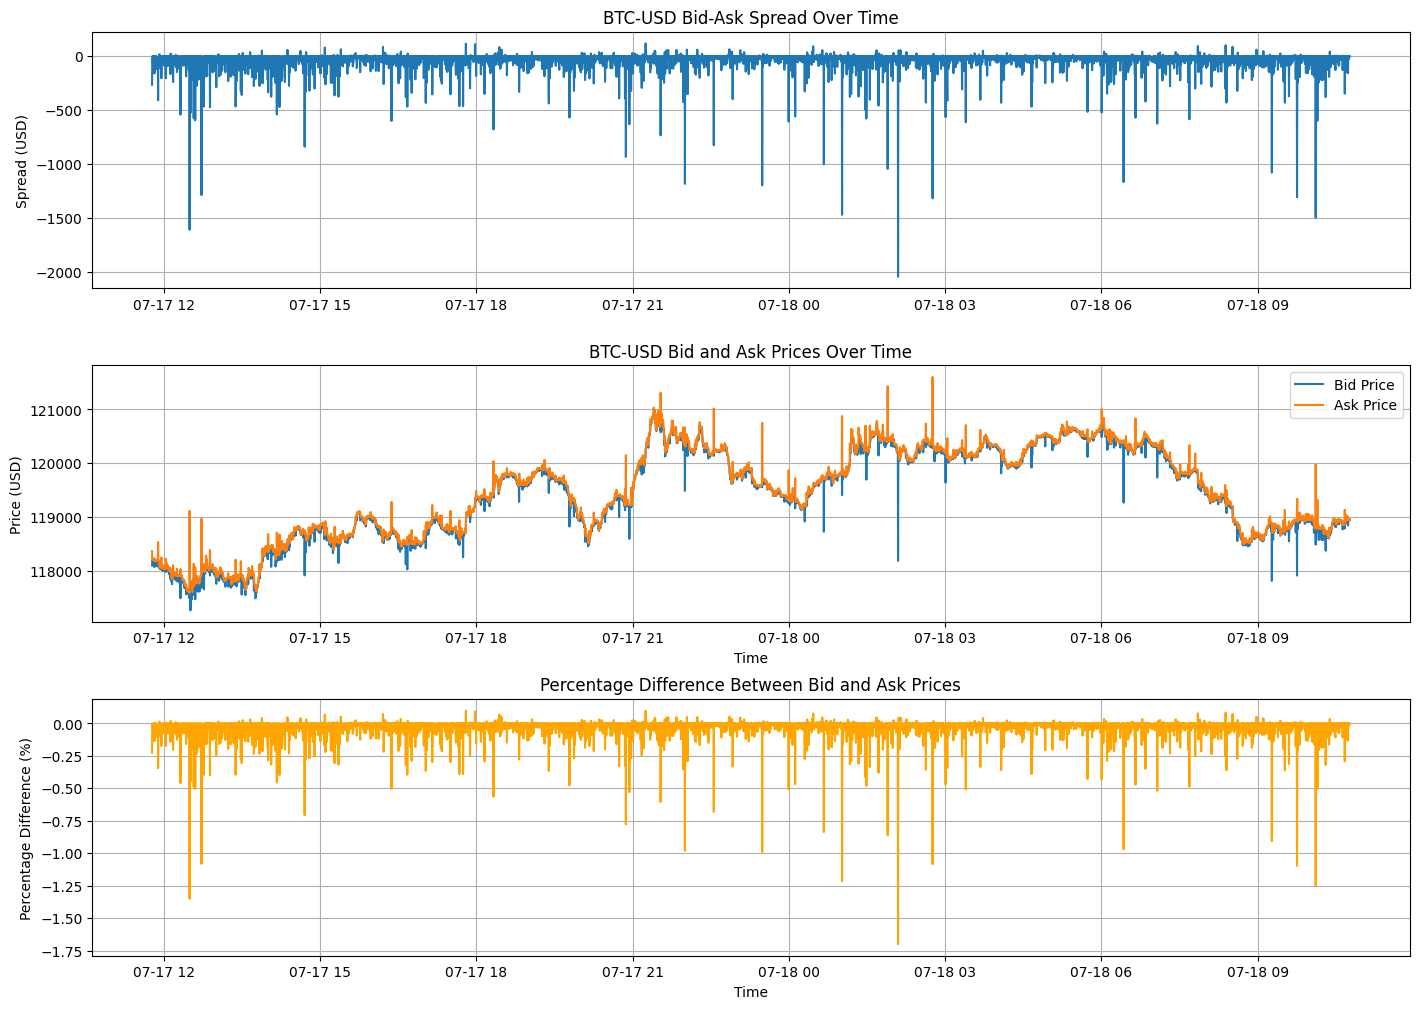

In [15]:
# Filter for asset pairs only
asset_1_name = asset_pair[asset_1]
asset_2_name = asset_pair[asset_2]

filtered_df = result_df[
    (
        (result_df["from_asset_name"] == asset_1_name)
        & (result_df["to_asset_name"] == asset_2_name)
    )
    | (
        (result_df["from_asset_name"] == asset_2_name)
        & (result_df["to_asset_name"] == asset_1_name)
    )
]

# Identify bid and ask orders
ask_df = filtered_df[
    filtered_df["from_asset_name"] == asset_1_name
]  # Selling asset_1 for asset_2 (ask)
bid_df = filtered_df[
    filtered_df["from_asset_name"] == asset_2_name
]  # Buying asset_1 with asset_2 (bid)

# Resample data to get time-based aggregation (per minute)
period = "15s"  # 15 seconds
bid_prices = bid_df.set_index("timestamp").resample(period)["price"].max()  # type: ignore
ask_prices = ask_df.set_index("timestamp").resample(period)["price"].min()  # type: ignore

# Calculate the spread
spread_df = pd.DataFrame({"bid": bid_prices, "ask": ask_prices})
spread_df["spread"] = spread_df["bid"] - spread_df["ask"]
spread_df = spread_df.dropna()

# Create a figure with two subplots
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.3)
fig = plt.figure(figsize=(17, 12))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Plot spread
ax1.plot(spread_df.index, spread_df["spread"])
ax1.set_title(f"{asset_1_name}-{asset_2_name} Bid-Ask Spread Over Time")
ax1.set_ylabel(f"Spread ({asset_2_name})")
ax1.grid(True)

# Plot bid and ask prices
ax2.plot(spread_df.index, spread_df["bid"], label="Bid Price")
ax2.plot(spread_df.index, spread_df["ask"], label="Ask Price")
ax2.set_title(f"{asset_1_name}-{asset_2_name} Bid and Ask Prices Over Time")
ax2.set_xlabel("Time")
ax2.set_ylabel(f"Price ({asset_2_name})")
ax2.legend()
ax2.grid(True)

# Plot percentage difference in ask price relative to bid price
spread_df["percentage_difference"] = (
    (spread_df["bid"] - spread_df["ask"]) / spread_df["ask"] * 100
)
ax3.plot(spread_df.index, spread_df["percentage_difference"], color="orange")
ax3.set_title("Percentage Difference Between Bid and Ask Prices")
ax3.set_xlabel("Time")
ax3.set_ylabel("Percentage Difference (%)")
ax3.grid(True)

plt.tight_layout()
plt.show()